In [1]:
from model_utils import configuration as cnf
from plotting import model_plots
from plotting import data_plots
from model_utils import initialisation as init
import model_modules
import pyomo.environ as pyo

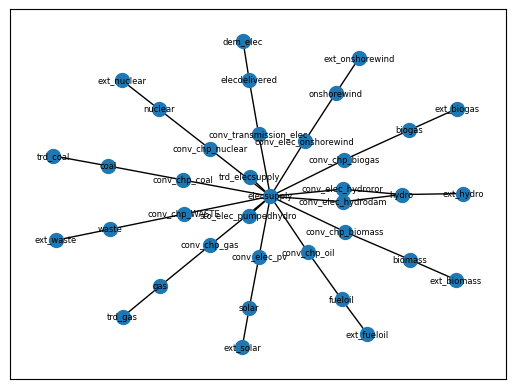

In [2]:
# Show network complexity
data_plots.plot_io_network(cnf.DATA)

In [3]:
# Model setup
model = init.init_model()

model_modules.trade.configure_sector(model)
model_modules.extraction.configure_sector(model)
model_modules.storage.configure_sector(model)

model_modules.electricity.configure_sector(model)
model_modules.transmission.configure_sector(model)
# model_modules.passenger.configure_sector(model)

model_modules.demands.configure_sector(model)

In [4]:
tot_cost_expr = model.dem_e_CostTotal + model.elec_e_CostTotal + model.ext_e_CostTotal + model.sto_e_CostTotal + model.trd_e_CostTotal + model.etrans_e_CostTotal
# tot_cost_expr += model.pass_e_CostTotal

In [5]:
model = init.run(model, tot_cost_expr)


Problem: 
- Name: unknown_copy
  Lower bound: 24572826038.35096
  Upper bound: 24572826038.35096
  Number of objectives: 1
  Number of constraints: 72300
  Number of variables: 51900
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 51900
  Number of nonzeros: 183184
  Sense: 1
  Number of solutions: 1
Solver: 
- Name: Gurobi 9.52
  Status: ok
  Wallclock time: 0.6559779644012451
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



# Plotting

<AxesSubplot:title={'center':"Modelled:Input:['elecsupply']"}, ylabel='TWh'>

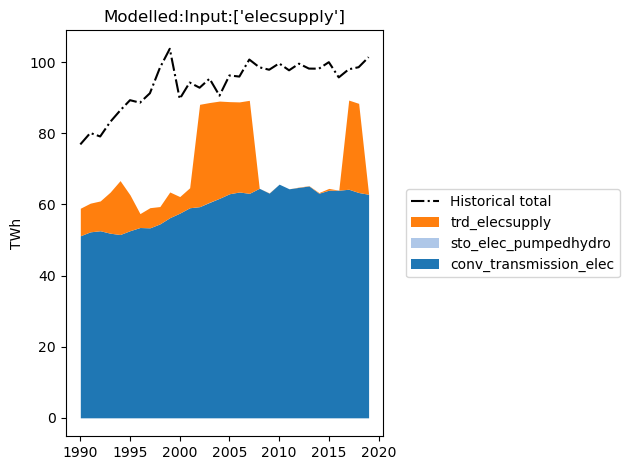

In [6]:
model_plots.plot_flow_fin(model, cnf.DATA, ["elecsupply"], unit="TWh", hist="elecsupply")

<AxesSubplot:title={'center':"Modelled:flow:['elecsupply']"}, ylabel='TWh'>

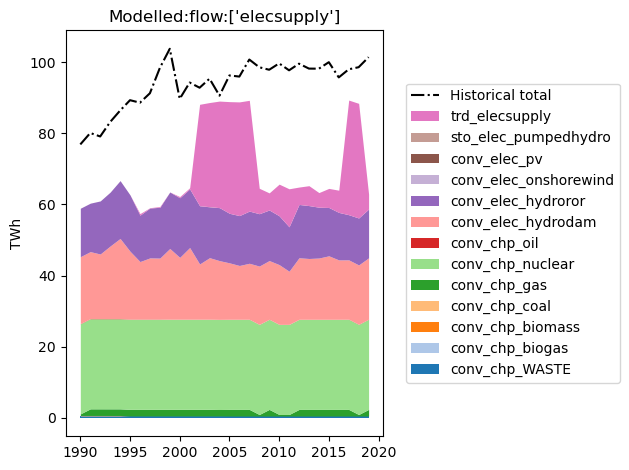

In [7]:
model_plots.plot_flow_fout(model, cnf.DATA, ["elecsupply"], unit="TWh", hist="elecsupply")

<AxesSubplot:title={'center':"Modelled:Tot Cap.:['_elec_', '_chp_']"}, ylabel='GW'>

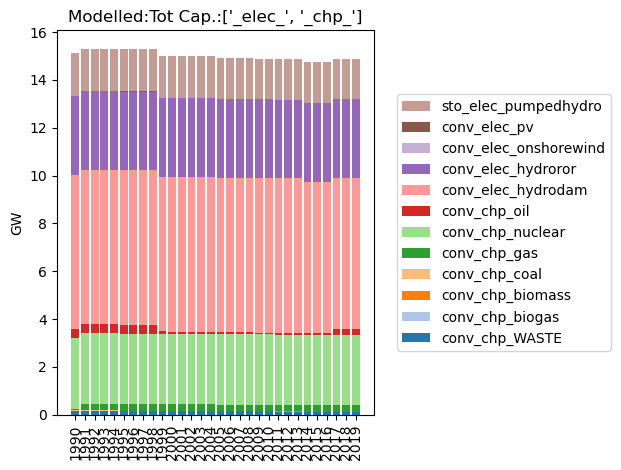

In [8]:
model_plots.plot_group_ctot(model, ["_elec_", "_chp_"], unit="GW")

In [ ]:
model_plots.plot_group_cnew(model, ["_elec_", "_chp_"], unit="GW")

In [ ]:
model_plots.plot_flow_fin(model, cnf.DATA, ["passshort", "passlong"], unit="Mpkm", hist="passenger")

In [ ]:
model_plots.plot_flow_fout(model, cnf.DATA, ["passshort", "passlong"], unit="Mpkm", hist="passenger")

In [ ]:
model_plots.plot_act(model, "conv_pass_RAILp", "Mvkm")

# Debug
Check your model run :)

In [ ]:
model.pass_c_flow_out["conv_pass_RAILp", 1990, 0, 0].pprint()

In [ ]:
total = 0
for e in model.PassTrans & model.Caps:
    for y in [model.Y.first()]:
        tech_max = model.ctot[e,y]() * cnf.DATA.get(e, "lf_max", y) * cnf.DATA.get(e, "capacity_to_activity", y)
        print(e+":", tech_max, "vs", model.e_TotalAnnualActivity[e, y]())
        total += tech_max
print(total)

In [ ]:
from pyomo.util import infeasible
infeasible.log_infeasible_constraints(model, log_expression=True, log_variables=True)
infeasible.log_infeasible_bounds(model)
# infeasible.log_close_to_bounds(model)

In [ ]:
import gurobi

model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})
m = gurobi.read("debug.lp")
m.optimize()
m.computeIIS()
m.write("debug_{0}.ilp".format("CHE"))